In [1]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

14628807/14628807 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4893335/4893335 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# IN - 텍스트로 로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [4]:
# IN - Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [5]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-3186768405.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/tmp/ipython-input-3186768405.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/tmp/ipython-input-3186768405.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [6]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 586    1    1    1    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   68  345   28   33    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  102    1    2    1    1  844    1    1  570    1    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


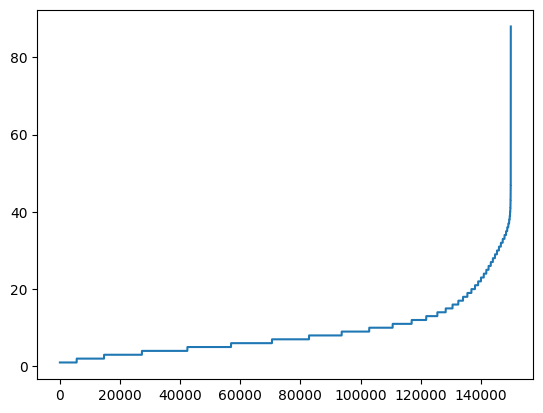

142587


In [7]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [8]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

# Week1에서 학습된 vectorize_layer 그대로 사용합니다.
test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)

test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [9]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,321 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6763 - loss: 0.5638 - val_accuracy: 0.7578 - val_loss: 0.4615
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.7495 - loss: 0.4657 - val_accuracy: 0.7581 - val_loss: 0.4612
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7557 - loss: 0.4545 - val_accuracy: 0.7550 - val_loss: 0.4603
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7556 - loss: 0.4499 - val_accuracy: 0.7598 - val_loss: 0.4569
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7567 - loss: 0.4479 - val_accuracy: 0.7593 - val_loss: 0.4565
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7587 - loss: 0.4435 - val_accuracy: 0.7429 - val_loss: 0.4722
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7615 - loss: 0.4390 - val_accuracy: 0.7552 - val_loss: 0.4609
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7623 - loss: 0

In [13]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4910, Test Accuracy: 0.7339


In [14]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9838
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0155
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0161
결과: 부정 😞


Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7688 - loss: 0.4229 - val_accuracy: 0.7499 - val_loss: 0.4634
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7747 - loss: 0.4200 - val_accuracy: 0.7527 - val_loss: 0.4708
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7745 - loss: 0.4189 - val_accuracy: 0.7518 - val_loss: 0.4708
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7755 - loss: 0.4159 - val_accuracy: 0.7555 - val_loss: 0.4717
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7779 - loss: 0.4113 - val_accuracy: 0.7577 - val_loss: 0.4754
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7826 - loss: 0.4073 - val_accuracy: 0.7558 - val_loss: 0.4751
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7802 - loss: 0.4067 - val_accuracy: 0.7395 - val_loss: 0.4825
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7853 - loss: 0

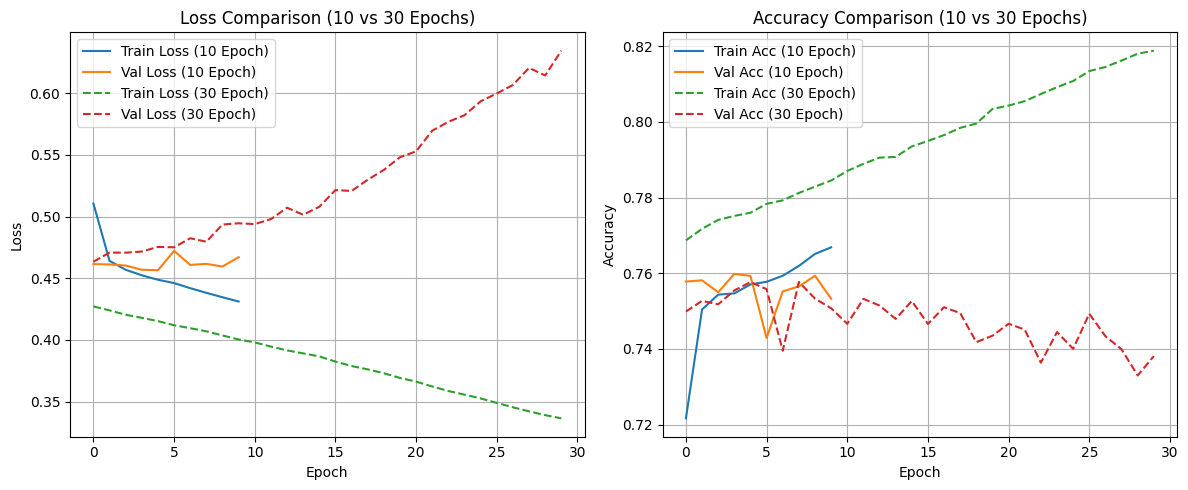

In [15]:
# Epoch 수를 30으로 늘려 다시 학습해봅니다.
history_overfit = model.fit(
    train_X, train_Y,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# 과적합 여부를 Loss/Accuracy 곡선으로 시각화
plt.figure(figsize=(12, 5))

# (1) Loss 비교
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (10 Epoch)')
plt.plot(history.history['val_loss'], label='Val Loss (10 Epoch)')
plt.plot(history_overfit.history['loss'], label='Train Loss (30 Epoch)', linestyle='--')
plt.plot(history_overfit.history['val_loss'], label='Val Loss (30 Epoch)', linestyle='--')
plt.title('Loss Comparison (10 vs 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 비교
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc (10 Epoch)')
plt.plot(history.history['val_accuracy'], label='Val Acc (10 Epoch)')
plt.plot(history_overfit.history['accuracy'], label='Train Acc (30 Epoch)', linestyle='--')
plt.plot(history_overfit.history['val_accuracy'], label='Val Acc (30 Epoch)', linestyle='--')
plt.title('Accuracy Comparison (10 vs 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()